In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import ipywidgets as widgets
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from IPython.display import display, clear_output
from datetime import datetime

# 3.1 Obtención de datos

In [3]:
def load_data(transactions_path, fraud_detection_path, sample_size, random_state=42):
    """
    Esta función lee dos archivos CSV, muestrea un número específico de transacciones legítimas, combina transacciones fraudulentas y legítimas, y luego combina los datos con un DataFrame de transacciones.

    Args:
    transactions_path (str): la ruta del archivo CSV para los datos de transacciones
    fraud_detection_path (str): la ruta del archivo CSV para los datos de detección de fraude
    sample_size (int): el número de transacciones legítimas a muestrear
    random_state (int, optional): un número utilizado para inicializar el generador de números aleatorios para reproducibilidad. El valor por defecto es 42.

    Returns:
    df (pd.DataFrame): un DataFrame que combina datos de transacciones y detección de fraude
    """

    # Cargar los conjuntos de datos
    fraud_detection = pd.read_csv(fraud_detection_path)
    transactions = pd.read_csv(transactions_path)

    # Separar transacciones fraudulentas y legítimas
    fraud = fraud_detection[fraud_detection['isFraud'] == 1]
    not_fraud = fraud_detection[fraud_detection['isFraud'] == 0]

    # Muestra de transacciones legítimas
    not_fraud_sample = not_fraud.sample(sample_size, random_state=random_state)

    # Combina las transacciones fraudulentas y legítimas en un nuevo DataFrame
    fraud_detection = pd.concat([fraud, not_fraud_sample], ignore_index=True)

    # Combina los datos de transacciones y detección de fraude
    df = pd.merge(transactions, fraud_detection, how="inner", left_on="CustomerID", right_on="Orig")

    return df


In [4]:
def process_data(df):
    """
    Esta función procesa un DataFrame de transacciones, incluyendo la limpieza, el enriquecimiento y la re-muestreo de los datos.

    Args:
    df (pd.DataFrame): el DataFrame de transacciones a procesar

    Returns:
    resampled_data (pd.DataFrame): un DataFrame que ha sido limpiado, enriquecido y re-muestreado
    """

    # Limpieza y enriquecimiento de datos
    df['CustomerID'] = df['CustomerID'].str.replace('C', '').astype(int)
    df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], dayfirst=True)
    df['TransactionYear'] = df['TransactionDate'].dt.year
    df['TransactionMonth'] = df['TransactionDate'].dt.month
    df['TransactionDay'] = df['TransactionDate'].dt.day
    df = df.drop(['TransactionDate', 'TransactionID', 'CustomerBirth','otherActor','amount','Orig','Dest'], axis=1)

    # Codificación de las características categóricas
    le = LabelEncoder()
    df['CustomerGender'] = le.fit_transform(df['CustomerGender'])
    le_location = LabelEncoder()
    df['TransactionLocation'] = le_location.fit_transform(df['TransactionLocation'])
    le_type = LabelEncoder()
    df['type'] = le_type.fit_transform(df['type'])

    # Elimina las filas donde 'CustomerGender' es igual a 2
    indices = df[df['CustomerGender'] == 2].index
    df = df.drop(indices)

    # Re-muestreo utilizando SMOTE
    X = df.drop(columns=['CustomerGender'], axis=1)
    y = df['CustomerGender']
    smote = SMOTE(sampling_strategy='auto')
    X_resampled, y_resampled = smote.fit_resample(X, y)
    df = pd.concat([X_resampled, y_resampled], axis=1)

    X = df.drop(columns=['isFraud'], axis=1)
    y = df['isFraud']
    smote = SMOTE(sampling_strategy='auto')
    X_resampled, y_resampled = smote.fit_resample(X, y)
    resampled_data = pd.concat([X_resampled, y_resampled], axis=1)

    return resampled_data

# 3.2 Procesamiento de datos y entrenamiento del modelo

In [5]:
def train_models(df):
    """
    Esta función divide los datos en conjuntos de entrenamiento y prueba, y luego entrena un modelo de Regresión Logística y un modelo Random Forest.
    """
    X_train, X_test, y_train, y_test = train_test_split(df.drop('isFraud', axis=1), df['isFraud'], test_size=0.2, random_state=42)
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)
    lr_predictions = lr_model.predict(X_test)
    rf_predictions = rf_model.predict(X_test)

    return X_train, X_test, y_train, y_test, lr_model, rf_model, lr_predictions, rf_predictions

In [6]:
def calculate_metrics(model_name, y_test, predictions):
    """
    Esta función calcula e imprime las métricas de un modelo.
    """
    print(f"\n{model_name} Metrics:")
    print(f'Accuracy: {accuracy_score(y_test, predictions)}')
    print(f'Confusion Matrix: \n{confusion_matrix(y_test, predictions)}')
    print(f'Classification Report: \n{classification_report(y_test, predictions)}')
    print(f'Recall: {recall_score(y_test, predictions)}')
    print(f'Precision: {precision_score(y_test, predictions)}')
    print(f'F1-Score: {f1_score(y_test, predictions)}')
    print(f'AUC: {roc_auc_score(y_test, predictions)}')
    print("")

In [7]:
def cross_val_and_test_metrics(X, y, X_test, y_test, model):
    """
    Esta función realiza la validación cruzada en un modelo y calcula las métricas del conjunto de prueba.
    """
    cv_scores = cross_val_score(model, X, y, cv=5)
    print(f"{model.__class__.__name__} CV scores:", cv_scores)
    print(f"{model.__class__.__name__} CV mean score:", np.mean(cv_scores))

    test_predictions = model.predict(X_test)
    print(f"{model.__class__.__name__} Test Metrics:")
    print("Accuracy:", accuracy_score(y_test, test_predictions))
    print("Recall:", recall_score(y_test, test_predictions))
    print("Precision:", precision_score(y_test, test_predictions))
    print("F1-Score:", f1_score(y_test, test_predictions))
    print("AUC:", roc_auc_score(y_test, test_predictions))
    print("")

    return test_predictions

# 3.3 Visualización de datos y explotación del producto

In [8]:
def create_widgets(df):
    """
    Crea y maneja los widgets de filtrado.
    """
    fraud_filter = widgets.Dropdown(options=['All', 'Fraud', 'Not Fraud'], description='Fraud Status:')
    customer_id_filter = widgets.Text(description='Customer ID:')
    apply_button = widgets.Button(description='Apply Filters')

    def apply_filters(sender):
        filtered_df = df.copy()
        if fraud_filter.value != 'All':
            filtered_df = filtered_df[filtered_df['isFraud'] == (fraud_filter.value == 'Fraud')]
        if customer_id_filter.value:
            filtered_df = filtered_df[filtered_df['CustomerID'] == int(customer_id_filter.value)]
        clear_output()
        display(filtered_df)

    apply_button.on_click(apply_filters)
    display(fraud_filter, customer_id_filter, apply_button)

In [9]:
def visualize_transaction_amount(df):
    """
    Visualiza la distribución de la cantidad de transacciones.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='TransactionAmount (eur)', hue='isFraud', bins=50, kde=True)
    plt.title('Distribución de la Cantidad de Transacción (eur) para transacciones legítimas y fraudulentas')
    plt.show()

In [10]:
def visualize_transaction_type_and_gender(df):
    """
    Visualiza el número de transacciones por tipo y género.
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='type', hue='isFraud')
    plt.title('Número de transacciones legítimas y fraudulentas por tipo')
    plt.xticks(rotation=90)
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='CustomerGender', hue='isFraud')
    plt.title('Número de transacciones legítimas y fraudulentas por género')
    plt.xticks(rotation=90)
    plt.show()

In [11]:
def visualize_fraud_over_time(df):
    """
    Visualiza el número de transacciones fraudulentas a lo largo del tiempo.
    """
    df['TransactionDate'] = df.apply(lambda row: datetime(int(row['TransactionYear']), int(row['TransactionMonth']), int(row['TransactionDay'])), axis=1)
    plt.figure(figsize=(10, 6))
    fraud_by_day = df[df['isFraud']==1].groupby('TransactionDate').count()['isFraud']
    plt.plot(fraud_by_day.index, fraud_by_day.values, label='Fraud')
    plt.title('Número de transacciones fraudulentas a lo largo del tiempo')
    plt.xticks(rotation=90)
    plt.show()

In [12]:
def display_shap_values(model, X):
    """
    Calcula y muestra los valores SHAP para un ejemplo.
    """
    explainer = shap.TreeExplainer(model)
    example = X.iloc[0,:]
    shap_values = explainer.shap_values(example)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], example)

# Main

In [13]:
if __name__ == "__main__":
    # 3.1. Obtención de datos
    # Obtención de datos
    fraud_detection, transactions = "data_BOC_fraudDetection.csv", "data_BOC_transactions.csv"
    # El número 118 indica las muestras que va a recoger, se ha obtado por hacer una reducción del conjunto
    # para no sesgar los resultados dado la desigualdad entre los casos fraudulentos y los no fraudulentos.
    # Se han hecho pruebas con el conjunto completo y los resultados no bajan de un 99% de aciertos, lo
    # que da de pensar que es posible que al crear tantas muestras con SMOTE exista un sobreentrenamiento.
    df = load_data(transactions, fraud_detection, 118)
    # Enriquecimiento y limpieza de datos
    df = process_data(df)

In [14]:
    # 3.2. Procesamiento de datos y entrenamiento del modelo
    X_train, X_test, y_train, y_test, lr_model, rf_model, lr_predictions, rf_predictions = train_models(df)
    calculate_metrics('Logistic Regression', y_test, lr_predictions)
    calculate_metrics('Random Forest', y_test, rf_predictions)
    lr_test_predictions = cross_val_and_test_metrics(X_test, y_test, X_test, y_test, lr_model)
    rf_test_predictions = cross_val_and_test_metrics(X_test, y_test, X_test, y_test, rf_model)

    lr_results_df = X_test.copy()
    lr_results_df['isFraud'] = lr_test_predictions

    rf_results_df = X_test.copy()
    rf_results_df['isFraud'] = rf_test_predictions


Logistic Regression Metrics:
Accuracy: 0.7558139534883721
Confusion Matrix: 
[[27  6]
 [15 38]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        33
           1       0.86      0.72      0.78        53

    accuracy                           0.76        86
   macro avg       0.75      0.77      0.75        86
weighted avg       0.78      0.76      0.76        86

Recall: 0.7169811320754716
Precision: 0.8636363636363636
F1-Score: 0.7835051546391751
AUC: 0.7675814751286448


Random Forest Metrics:
Accuracy: 0.9302325581395349
Confusion Matrix: 
[[30  3]
 [ 3 50]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        33
           1       0.94      0.94      0.94        53

    accuracy                           0.93        86
   macro avg       0.93      0.93      0.93        86
weighted avg       0.93      0.93      0.93        86


In [15]:
# Consulta dinámica
create_widgets(rf_results_df)

Dropdown(description='Fraud Status:', options=('All', 'Fraud', 'Not Fraud'), value='All')

Text(value='', description='Customer ID:')

Button(description='Apply Filters', style=ButtonStyle())

In [16]:
# Ejemplo de ejecución de consulta dinámica sobre todas las transacciones fraudulentas
create_widgets(rf_results_df)

,CustomerID,TransactionLocation,TransactionAmount (eur),type,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,TransactionYear,TransactionMonth,TransactionDay,CustomerGender,isFraud,TransactionDate
420,7691744,18,597.975599,1,6.229228e+03,0.0,3577.54185,3297.466448,2016,8,7,1,1,2016-08-07
75,6727014,23,506.000000,1,0.000000e+00,0.0,249091.94000,456736.900000,2016,8,9,1,0,2016-08-09
177,6288021,170,695.000000,3,4.414456e+05,0.0,0.00000,0.000000,2016,8,23,1,1,2016-08-23
30,3010531,26,-195.000000,3,1.055000e+03,0.0,0.00000,0.000000,2016,8,9,1,1,2016-08-09
362,4907452,45,1369.916514,3,3.850833e+04,0.0,0.00000,0.000000,2016,8,8,0,1,2016-08-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,7821175,70,1072.473937,1,1.724600e+04,0.0,0.00000,17246.000000,2016,8,6,0,1,2016-08-06
57,6920387,53,-717.000000,1,0.000000e+00,0.0,59672.00000,0.000000,2016,8,16,0,0,2016-08-16
124,3041362,148,632.730000,3,8.535469e+04,0.0,0.00000,0.000000,2016,8,10,1,1,2016-08-10
24,4832874,104,155.000000,3,2.970786e+04,0.0,0.00000,0.000000,2016,8,11,1,1,2016-08-11


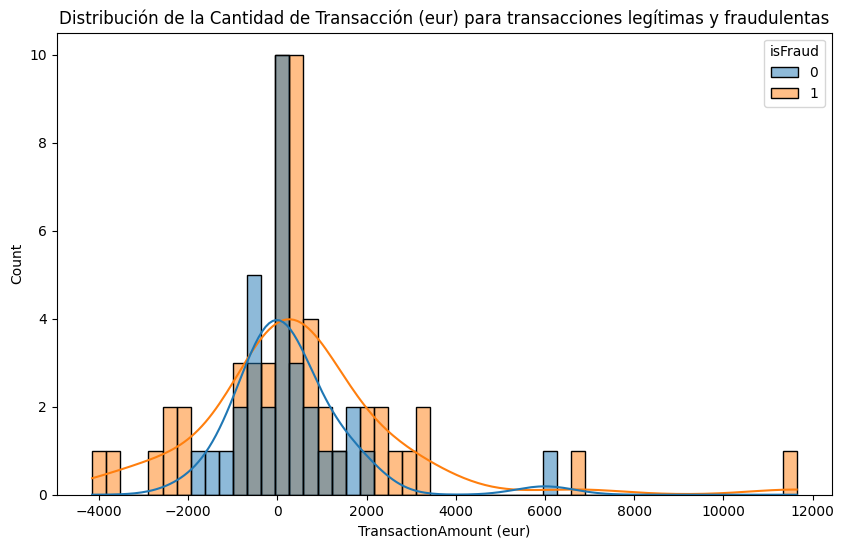

In [17]:
visualize_transaction_amount(rf_results_df)

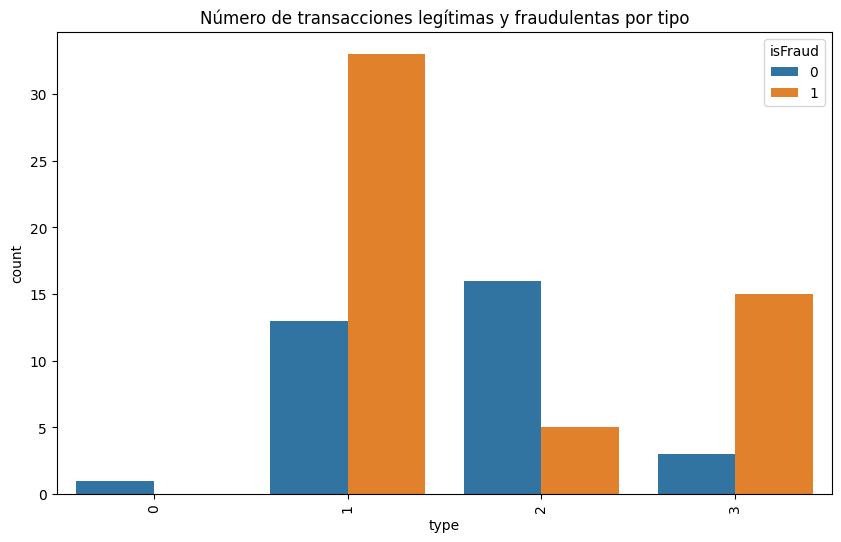

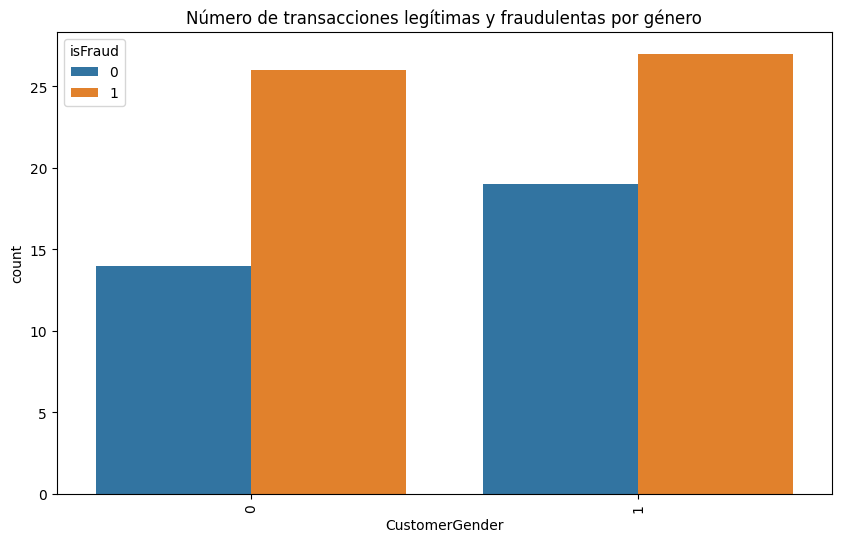

In [18]:
visualize_transaction_type_and_gender(rf_results_df)

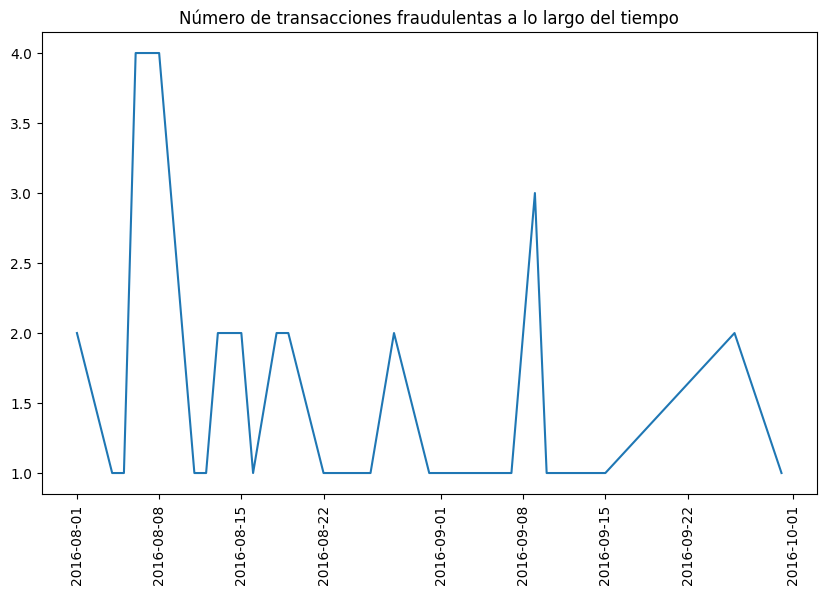

In [19]:
visualize_fraud_over_time(rf_results_df)

In [20]:
display_shap_values(rf_model, X_test)